### Importing libraries and csv files

In [188]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
# len(tf.config.list_physical_devices('GPU'))

In [189]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Login in shell (required only once)
# !wandb login

# Login in notebook (required only once)
import wandb
wandb.login()

# Initialize a WandbLogger
from deepchem.models import WandbLogger
logger = WandbLogger(name="embeddings loss", project="deepchem-trial")


# Set `wandb_logger` when creating `KerasModel`
# import deepchem as dc
# # Log training loss to wandb
# model = dc.models.KerasModel(…, wandb_logger=logger)
# model.fit(…)

# # Log validation metrics to wandb using ValidationCallback
# import deepchem as dc
# vc = dc.models.ValidationCallback(…)
# model = KerasModel(…, wandb_logger=logger)
# model.fit(…, callbacks=[vc])
# logger.finish()

In [73]:
import deepchem as dc
import pandas as pd
import numpy as np
from tqdm import tqdm,trange
from deepchem.models.optimizers import Adam, ExponentialDecay
from pathlib import Path

path = Path()
train_csv = path.glob("../datasets/chembl/chembl_train.csv")
test_csv = path.glob("../datasets/chembl/chembl_test.csv")
valid_csv = path.glob("../datasets/chembl/chembl_valid.csv")
train_dataset = pd.read_csv(train_csv.__next__())
test_dataset = pd.read_csv(test_csv.__next__())
valid_dataset = pd.read_csv(valid_csv.__next__())

In [114]:
# eliminating SMILES > 100 in length
def df_masker(df, length=100):
    '''
    df is a dataframe object with a SMILES column
    length is the cutoff for the SMILES string lengths
    '''
    mask = (df['SMILES'].str.len() <= length)
    df = df.loc[mask]
    print(df)
    print('\n')
    return df

In [115]:
train_dataset = df_masker(train_dataset)
test_dataset = df_masker(test_dataset)
valid_dataset = df_masker(valid_dataset)

                                                   SMILES
0                    Oc1ccccc1\C=N\c2ccccc2\N=C\c3ccccc3O
2                            Oc1cnc2[nH]c3cnc(cc3c2c1)C#N
3       COc1c(C)c2COC(=O)c2c(O)c1CCOP(=O)(O)CCSc3nc4c(...
4            C[C@H]1CN(CCCN(c2ccccc2)c3ccccc3)C[C@H](C)N1
5       COc1ccc(cc1OCCN2CCCCC2)C3=C(C)CN(C3=O)c4ccc(Cl...
...                                                   ...
195632          O=C([C@@H]1CCc2cc(ccc2C1)c3ccccc3)c4occn4
195633  CS(=O)(=O)Nc1cccc(OCCN2CCC(Cc3ccc4CCC(=O)Nc4c3...
195634  COc1ccc(CC(=O)NC(=N)N[C@H](CC(C)C)C(=O)NCc2ccc...
195635     CSc1ccc(cc1)c2cn(C)nc2C3CCC(F)(F)CC3C(=O)NCC#N
195636       Oc1c2C(=O)N(Cc3ccccc3Br)C(=O)c2c(O)c4nccnc14

[187621 rows x 1 columns]


                                                  SMILES
0      CCN(CCCc1ccccc1)[C@@H]2CC[C@@H](C[C@H]2O)OCc3c...
1      CN1CCN(CC1)c2cc(Nc3ncc(s3)c4ccc(NC(=O)Nc5ccccc...
2                 FC(F)(F)c1ccc(Sc2ccc3CC4CNCCN4c3c2)cc1
3      CCCc1nc2ccccc2n1Cc3ccc(cc3)c4ccccc4S(=O)

#### using numpy arrays as inputs

In [116]:

train_smiles = pd.DataFrame(train_dataset).to_numpy().astype(str)
test_smiles = pd.DataFrame(test_dataset).to_numpy().astype(str)
valid_smiles = pd.DataFrame(valid_dataset).to_numpy().astype(str)

# train_smiles = train_smiles["SMILES"]
# valid_smiles = valid_smiles["SMILES"]
# test_smiles = test_smiles["SMILES"]


In [134]:
print(train_smiles)

['Oc1ccccc1\\C=N\\c2ccccc2\\N=C\\c3ccccc3O' 'Oc1cnc2[nH]c3cnc(cc3c2c1)C#N'
 'COc1c(C)c2COC(=O)c2c(O)c1CCOP(=O)(O)CCSc3nc4c(N)ncnc4n3[C@H]5O[C@@H](CO)[C@H](O)[C@@H]5O'
 ... 'COc1ccc(CC(=O)NC(=N)N[C@H](CC(C)C)C(=O)NCc2ccc(cc2)c3nnn[nH]3)cc1OC'
 'CSc1ccc(cc1)c2cn(C)nc2C3CCC(F)(F)CC3C(=O)NCC#N'
 'Oc1c2C(=O)N(Cc3ccccc3Br)C(=O)c2c(O)c4nccnc14']


In [118]:
# flatten the numpy arrays
train_smiles = np.squeeze(train_smiles)
test_smiles = np.squeeze(test_smiles)
valid_smiles = np.squeeze(valid_smiles)

In [149]:
print(train_smiles)


['Oc1ccccc1\\C=N\\c2ccccc2\\N=C\\c3ccccc3O' 'Oc1cnc2[nH]c3cnc(cc3c2c1)C#N'
 'COc1c(C)c2COC(=O)c2c(O)c1CCOP(=O)(O)CCSc3nc4c(N)ncnc4n3[C@H]5O[C@@H](CO)[C@H](O)[C@@H]5O'
 ... 'COc1ccc(CC(=O)NC(=N)N[C@H](CC(C)C)C(=O)NCc2ccc(cc2)c3nnn[nH]3)cc1OC'
 'CSc1ccc(cc1)c2cn(C)nc2C3CCC(F)(F)CC3C(=O)NCC#N'
 'Oc1c2C(=O)N(Cc3ccccc3Br)C(=O)c2c(O)c4nccnc14']


In [120]:
tokens = set()

# each SMILES is in its own array
# for s in train_smiles:
#     for c in s:
#         tokens = tokens.union(set(cc for cc in c))

# for s in test_smiles:
#     for c in s:
#         tokens = tokens.union(set(cc for cc in c))

# for s in valid_smiles:
#     for c in s:
#         tokens = tokens.union(set(cc for cc in c))

        
        
# All SMILES in one array
for s in train_smiles:
    tokens = tokens.union(set(c for c in s))

for s in test_smiles:
    tokens = tokens.union(set(c for c in s))

for s in valid_smiles:
    tokens = tokens.union(set(c for c in s))


# sort tokens
tokens = sorted(list(tokens))
print(tokens)
print("Number of tokens: ", len(tokens))

## using molnet data (takes a while to download)
# tasks, datasets, transformers = dc.molnet.load_chembl25(splitter='stratified')
# train_dataset, valid_dataset, test_dataset = datasets
# train_smiles = train_dataset.ids
# valid_smiles = valid_dataset.ids
# test_smiles = test_dataset.ids


['#', '%', '(', ')', '+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'A', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'e', 'i', 'l', 'n', 'o', 'r', 's']
Number of tokens:  40


In [122]:
# verify that the longest SMILES string is 100
print(max(len(x) for x in valid_smiles))

100


### Viewing the distribution of SMILES lengths

(array([0.00015286, 0.00040126, 0.0016146 , 0.00330563, 0.00878953,
        0.01199962, 0.02190695, 0.02201204, 0.03109774, 0.02372217,
        0.02783988, 0.0184198 , 0.0171969 , 0.0097067 , 0.00856024,
        0.00510175, 0.00428967, 0.00226426, 0.00228337, 0.00155728]),
 array([ 10. ,  14.5,  19. ,  23.5,  28. ,  32.5,  37. ,  41.5,  46. ,
         50.5,  55. ,  59.5,  64. ,  68.5,  73. ,  77.5,  82. ,  86.5,
         91. ,  95.5, 100. ]),
 <BarContainer object of 20 artists>)

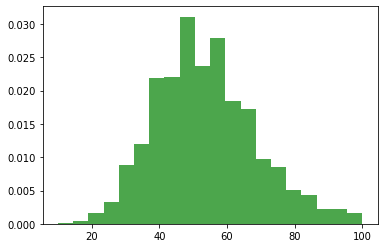

In [123]:
import matplotlib.pyplot as plt
smiles_list = [len(x) for x in valid_smiles]
plt.hist(smiles_list, 20, density = 1, color ='green', alpha = 0.7)

### model setup and training

In [169]:
# # Use this when the numpy array is not squeezed
# train_max = []
# for s in train_smiles:
#     for y in s:
#         train_max.append(len(y))
        
        
# # print(train_max)

# test_max = []
# for s in test_smiles:
#     for y in s:
#         test_max.append(len(y))
        
        
# # print(test_max)

# valid_max = []
# for s in valid_smiles:
#     for y in s:
#         valid_max.append(len(y))
        
        
# # print(valid_max)
# max_length = max(len(x) for x in s for s in train_smiles)
# max_length = max(max(train_max), max(test_max), max(valid_max))


# Use this when the numpy arrays have been squeezed
train_max = max(len(x) for x in train_smiles)
test_max = max(len(x) for x in test_smiles)
valid_max = max(len(x) for x in valid_smiles)
max_length = max(train_max, test_max, valid_max)
print("Max length of SMILES: ",max_length)

# model params
# metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
# vc_valid = ValidationCallback(valid_smiles, interval=5, metrics=[metric])
batch_size = 128
embed=32
epoch = 1
loss = []
batches_per_epoch = len(train_smiles)/batch_size
model = dc.models.SeqToSeq(tokens,
                           tokens,
                           100,
                           encoder_layers=4,
                           decoder_layers=4,
                           embedding_dimension=embed,
                           model_dir=f"chembl25-weights_{epoch}epochs-11-07-2022-test",
                           batch_size=batch_size,
                           learning_rate=ExponentialDecay(0.001, 0.9, batches_per_epoch), log_frequency=1) 
#,wandb_logger=logger),callbacks=[vc_valid], all_losses = loss


# # When numpy arrays have not been squeezed
# def generate_sequences(epochs):
#     for i in trange(epochs):
#         for s in train_smiles:
#             for ss in s:
# #                 print(ss)
#                 yield (ss, ss)
                

# When numpy arrays have been squeezed
def generate_sequences(epochs):
    for i in trange(epochs):
        for ss in train_smiles:
            yield (ss, ss)


Max length of SMILES:  100


In [153]:
counter = 0
for ss in train_smiles:
    if counter > 10:
        break
        
    print(ss)
    counter +=1

Oc1ccccc1\C=N\c2ccccc2\N=C\c3ccccc3O
Oc1cnc2[nH]c3cnc(cc3c2c1)C#N
COc1c(C)c2COC(=O)c2c(O)c1CCOP(=O)(O)CCSc3nc4c(N)ncnc4n3[C@H]5O[C@@H](CO)[C@H](O)[C@@H]5O
C[C@H]1CN(CCCN(c2ccccc2)c3ccccc3)C[C@H](C)N1
COc1ccc(cc1OCCN2CCCCC2)C3=C(C)CN(C3=O)c4ccc(Cl)c(Cl)c4
Oc1ccc2[nH]cc(CCNC(=O)Oc3ccc(Cl)cc3)c2c1
CC1(C)N(Cc2cccc(I)c2)C(=O)N(C1=O)c3ccc(C#N)c(c3)C(F)(F)F
CN1CC[C@]23Cc4nc5ccccc5cc4C[C@H]2[C@H]1Cc6ccc(O)cc36
CN(C)CC1=Nc2c(sc3ccc(cc23)c4ccc(O)cc4)C(=O)N1
C[C@H](\C=C(/C)\C=C\C(=O)NO)C(=O)c1ccc(cc1)N(C)C
CC1=C(C)c2ccc(OS(=O)(=O)N)cc2OC1=O


In [186]:
print(model.fit_sequences(generate_sequences(epoch)))
print("Training complete")

100%|██████████| 1/1 [00:35<00:00, 35.14s/it]

None
Training complete


In [185]:
super(dc.models.SeqToSeq, model).

AttributeError: 'super' object has no attribute 'loss_fn'

In [156]:
valid_smiles[10]

'CC[C@@H](Cc1ccc(OC)c(c1)C(=O)NCc2ccc(Oc3ccc(F)cc3)cc2)C(=O)O'

In [131]:
len("CC1Cc2nn(C)c(c3ccccc3Cl)c2c4nc(Nc5ccn(C)n5)ncc14")

48

In [158]:
model.predict_embeddings([valid_smiles[11]])

array([[ 0.00468747,  0.9998974 ,  0.98171103,  0.08479983, -0.9947344 ,
        -0.1539325 ,  0.17027095,  0.9983924 ,  0.40384707, -0.99999666,
         0.56521493,  0.99658406,  0.19168407,  0.99888825, -0.1928592 ,
        -0.1175536 , -0.99995583, -0.16622539,  0.9971117 , -0.02710001,
         0.34984538,  0.16314808,  0.07148624,  0.99611765,  0.3329139 ,
        -0.98738325,  0.9353697 ,  0.42473713,  0.9998943 ,  0.99933547,
         0.37530223, -0.5836238 ]], dtype=float32)

In [159]:
model.predict_from_sequences(['CC', 'CCC'])

[['C', 'O', 'N'], ['O', '1', '1', '1']]

In [148]:
train_smiles[0], predicted[0]

('Oc1ccccc1\\C=N\\c2ccccc2\\N=C\\c3ccccc3O',
 ['C',
  'C',
  '1',
  '1',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  '3'])

In [163]:
predicted = model.predict_from_sequences(test_smiles)
count = 0
for s,p in zip(test_smiles, predicted):
    if ''.join(p) == s:
        count += 1
print('reproduced', count, f"of {len(test_smiles)} validation SMILES strings")

reproduced 1 of 23347 validation SMILES strings


In [167]:
super(self,model).loss_fn

NameError: name 'self' is not defined